## Experiment Setup

###  Random seed / Colab / CUDA related

In [0]:
import time
import datetime
import sys
import os

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/bayesian-dl-experiments
experiment_comparison_toy.ipynb  LICENSE    ronald_bdl
experiment_nn_capacity_1.ipynb	 README.md  test_results


### Third party libraries (NumPy, PyTorch, Pyro)

In [0]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
NumPy Version: 1.17.4
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [0]:
# More imports...
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets, models
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

CUDA Version: 10.1.243
cuDNN Version: 7603


### Toy dataset settings

In [0]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [0]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.5

# L2 regularization strength
reg_strength = 0.3

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.01

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 10000

### Directory path to save results

In [0]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(reg_strength) 
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [0]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [0]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
uncertainty_methods['mc_dropout'] = models.FCNetMCDropout(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    dropout_rate=dropout_rate,
    dropout_type='bernoulli',
)

# Vanilla Variational Inference
uncertainty_methods['vi'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

# HMC (NUTS)
uncertainty_methods['hmc'] = models.FCNetPyro(
    input_dim=dataset.n_features, 
    output_dim=dataset.n_targets,
    hidden_dim=100,
    n_hidden=0,
    torch_device=torch_device,
)

## Train the network

### Train/test the model

In [10]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=len(dataset))
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.03})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = NUTS(network)
            mcmc = MCMC(kernel, num_samples=30000)
            
        pyro.clear_param_store()
    
    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNetMCDropout):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    if loss_function_type in ('test_ll_mc', 'rmse_mc'):
                        _, _, _, metrics = network.predict_dist(
                            inputs, n_predictions, y_test=targets, reg_strength=reg_strength)

                        if loss_function_type == 'test_ll_mc':
                            total_loss = -(metrics[loss_function_type])
                    else:
                        total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNetMCDropout(
  (input): ModuleDict(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (relu): ReLU()
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)

[iteration 0001] loss: 91.7215
[iteration 0101] loss: 93.7411
[iteration 0201] loss: 82.2294
[iteration 0301] loss: 82.9163
[iteration 0401] loss: 86.9193
[iteration 0501] loss: 117.8862
[iteration 0601] loss: 60.2856
[iteration 0701] loss: 82.2199
[iteration 0801] loss: 113.0125
[iteration 0901] loss: 69.4635
[iteration 1001] loss: 90.6076
[iteration 1101] loss: 93.8542
[iteration 1201] loss: 63.2753
[iteration 1301] loss: 127.0586
[iteration 1401] loss: 80.9526
[iteration 1501] loss: 76.0367
[iteration 1601] loss: 95.2032
[iteration 1701] loss: 86.0635
[iteration 1801] loss: 75.2254
[iteration 1901] loss: 81.1335
[iteration 2001] loss: 89.1564
[iteration 2101] loss: 76.9563
[iteration 2201] loss: 86.6326
[iteration 2301] loss: 

Warmup:   0%|          | 0/60000 [00:00, ?it/s]

final loss = 37916.04009246826
training time = 15.671032905578613 seconds

Now running hmc
FCNetPyro(
  (input): PyroModuleDict(
    (linear): PyroLinear(in_features=1, out_features=100, bias=True)
    (relu): PyroReLU()
  )
  (output): PyroLinear(in_features=100, out_features=1, bias=True)
  (guide): AutoDiagonalNormal()
)



Sample: 100%|██████████| 60000/60000 [12:10, 82.17it/s, step size=8.30e-01, acc. prob=0.991]


final loss = 37916.04009246826
training time = 730.3157639503479 seconds



testing time = 1.2370712757110596 seconds

Mean = tensor([-46.0061, -44.5738, -43.1352, -41.6134, -40.2247, -38.8285, -37.2368,
        -35.7875, -34.4195, -32.9235, -31.5541, -29.9369, -28.4007, -27.0519,
        -25.5178, -24.0373, -22.6656, -21.1423, -19.6705, -18.2024, -16.7029,
        -15.2590, -13.8299, -12.4098, -10.9652,  -9.5323,  -8.2619,  -6.9660,
         -5.9091,  -5.1583,  -4.5695,  -4.1172,  -3.6854,  -3.2612,  -2.9251,
         -2.5926,  -2.2698,  -1.9671,  -1.6753,  -1.3587,  -1.0900,  -0.7783,
         -0.4544,  -0.1406,   0.2254,   0.5978,   0.9778,   1.3488,   1.6990,
          2.0576,   2.3863,   2.6544,   2.8576,   3.0131,   3.1502,   3.2785,
          3.3990,   3.5145,   3.6471,   3.7762,   3.8850,   4.0115,   4.1338,
          4.2570,   4.3657,   4.4921,   4.6235,   4.7467,   4.8960,   4.9909,
          5.1073,   5.2203,   5.3474,   5.4881,   5.6993,   5.9707,   6.4225,
          7.1094,   7.7844,   8.6165,   9.9111,  11.4312,  13.3516,  15.4580,
         17.70

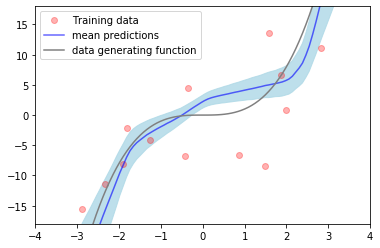

testing time = 6.354349136352539 seconds

Mean = tensor([-2.5261, -2.5948, -2.2513, -1.8308, -1.7490, -1.5026, -1.0594, -1.0014,
        -0.6054, -0.3311, -0.0891,  0.0719,  0.4221,  0.5214,  0.8031,  1.1445,
         1.3394,  1.5684,  1.8275,  2.0588,  2.3051,  2.5362,  2.7182,  3.0328,
         3.4821,  3.7575,  4.1913,  4.3971,  4.6338,  5.2837,  5.6673,  6.2388,
         6.5738,  7.0357,  7.2768,  7.5732,  7.9250,  8.4295,  8.5305,  8.7943,
         9.1239,  9.3995,  9.7259,  9.4257,  9.0899,  8.9408,  8.3942,  8.2652,
         7.3959,  6.9660,  6.5542,  6.3455,  6.6207,  6.6680,  6.7518,  7.1245,
         7.5374,  7.8095,  8.1171,  8.7381,  9.2205,  9.7197, 10.3206, 10.9081,
        11.3814, 11.7709, 12.5284, 12.8112, 13.4233, 13.9646, 14.4048, 14.8432,
        15.2237, 15.9009, 16.5594, 17.0276, 17.5400, 18.2040, 18.7561, 19.1358,
        19.5911, 20.1635, 20.8053, 21.3747, 21.9761, 22.5428, 23.1076, 23.5973,
        24.2770, 24.9410, 25.3171, 25.9121, 26.5715, 27.0624, 27.8170, 

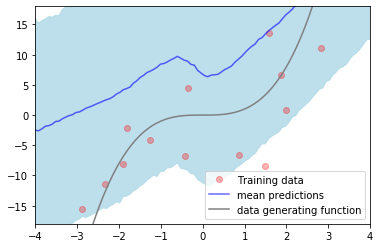

testing time = 6.180188179016113 seconds

Mean = tensor([-0.8229, -0.7075, -0.6138, -0.3483, -0.2756, -0.0990,  0.0679,  0.2118,
         0.4320,  0.5139,  0.4341,  0.8059,  0.8349,  0.7993,  1.1035,  1.4360,
         1.6838,  2.0461,  2.2582,  2.3878,  2.7551,  2.9810,  3.0743,  3.6684,
         4.0059,  4.2059,  4.3053,  4.5167,  4.6618,  4.8305,  4.7109,  5.1953,
         5.3366,  5.4225,  5.4986,  5.8451,  5.7527,  5.6981,  5.5916,  5.5270,
         5.1336,  4.9464,  4.3505,  4.0834,  3.6494,  3.5316,  3.3606,  3.0124,
         2.7893,  2.2635,  1.9471,  1.2273,  0.3375, -0.3693, -1.0399, -1.8450,
        -2.3758, -3.1842, -3.4939, -4.0542, -4.2533, -4.6653, -4.7693, -4.6213,
        -4.6307, -4.6436, -4.4807, -4.4871, -3.8836, -4.0221, -3.9837, -3.9138,
        -3.9422, -3.7528, -3.7267, -3.7779, -3.6841, -3.9933, -4.0639, -4.0753,
        -4.2366, -3.9906, -4.1234, -4.0532, -4.0047, -3.9946, -4.0620, -3.9497,
        -3.9058, -3.6610, -3.8714, -3.7611, -3.7360, -3.8375, -3.6258, 

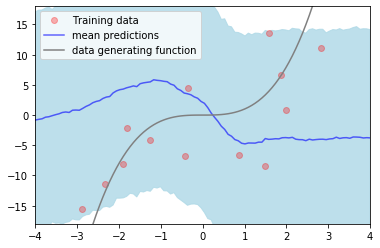

In [11]:
X_test = X_test.to(torch_device)
X_test_cpu = X_test.cpu()

for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean predictions', alpha=0.6)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'))
    
    plt.show()